In [1]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [2]:
# Download stock data
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data


In [3]:
# Feature engineering
def prepare_features(data):
    data['Return'] = data['Close'].pct_change()
    data['Volatility'] = data['Close'].rolling(window=5).std()
    data['Momentum'] = data['Close'] / data['Close'].shift(5) - 1
    data['AvgVolume'] = data['Volume'].rolling(window=5).mean()
    data['PriceDirection'] = (data['Close'].shift(-1) > data['Close']).astype(int)  # 1 if price up, 0 if down
    data = data.dropna()
    return data

In [4]:
# Train and evaluate model
def train_model(data):
    X = data[['Open', 'High', 'Low', 'Volume', 'Return', 'Volatility', 'Momentum', 'AvgVolume']]
    y = data['Close']
    y_class = data['PriceDirection']  # For classification

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)

    # Regression model for price prediction
    reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
    reg_model.fit(X_train, y_train)
    y_pred = reg_model.predict(X_test)
    
    model_filename = 'randomforest.pkl'
    
    # Save the model
    joblib.dump(reg_model,model_filename)
    print(f"Model saved to {model_filename}")

    # Classification model for price direction
    clf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    clf_model.fit(X_train_c, y_train_c)
    y_pred_class = np.round(clf_model.predict(X_test_c))

    # Regression metrics
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (Regression): {mse:.4f}")

    # Classification metrics
    accuracy = accuracy_score(y_test_c, y_pred_class)
    print(f"Accuracy (Classification): {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test_c, y_pred_class))

    return reg_model, clf_model, X_test, y_test, y_pred


In [5]:
# Plot results
def plot_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test.values, label="Actual Price", color="blue")
    plt.plot(y_test.index, y_pred, label="Predicted Price", color="orange")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.title("Actual vs Predicted Stock Prices")
    plt.legend()
    plt.show()

In [6]:
ticker = "AAPL" 
start_date = "2020-01-01"
end_date = "2023-11-25"

In [7]:
# Load data
stock_data = get_stock_data(ticker, start_date, end_date)
stock_data = prepare_features(stock_data)

[*********************100%***********************]  1 of 1 completed


In [8]:
# Predict future prices
def predict_future_prices(model, recent_data):
    prediction = model.predict(recent_data)
    return prediction

In [9]:
# Train model
reg_model, clf_model, X_test, y_test, y_pred = train_model(stock_data)

Model saved to randomforest.pkl
Mean Squared Error (Regression): 1.0633
Accuracy (Classification): 0.5357

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.45      0.51       105
           1       0.50      0.64      0.56        91

    accuracy                           0.54       196
   macro avg       0.54      0.54      0.53       196
weighted avg       0.55      0.54      0.53       196



In [10]:
# Prepare recent data for prediction
recent_data = stock_data.iloc[-5:][['Open', 'High', 'Low', 'Volume', 'Return', 'Volatility', 'Momentum', 'AvgVolume']]
future_price = predict_future_prices(reg_model, recent_data)
print("Predicted Future Prices:", future_price)

Predicted Future Prices: [189.76849915 191.27339783 190.77009857 191.26499878 190.14990036]


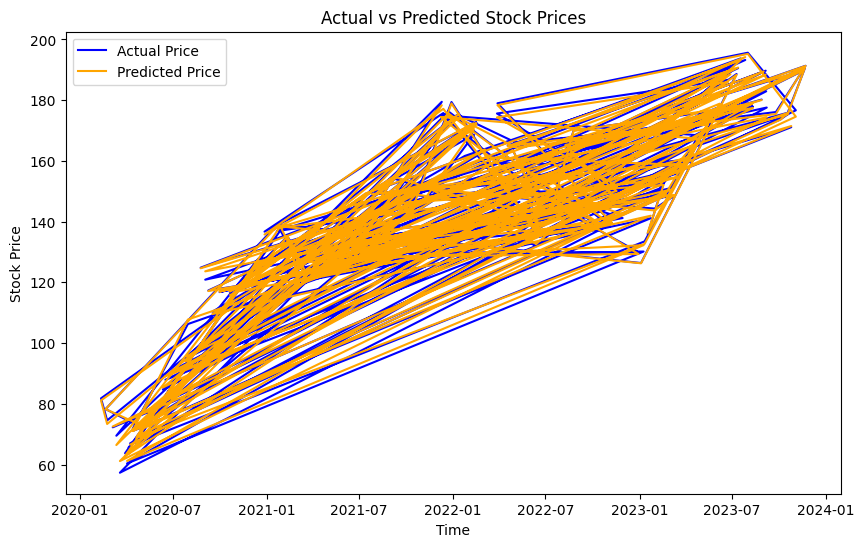

In [11]:
# Plot results
plot_results(y_test, y_pred)